In [9]:
import sys
sys.path.append('..')
import os
import pandas as pd
import copy
import numpy as np
import tree_util
import seaborn as sns 
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection as fdr
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib as mpl 
mpl.rcParams['pdf.fonttype'] = 42
import warnings 
warnings.filterwarnings('ignore')
def format_func(value, tick_number):
    return f"{value:.2e}"

In [10]:
def ex_df(d_df, profile, sname):
    sp_list = list(set(profile.columns).intersection(set(d_df.index)))
    sp_d_df = d_df.loc[sp_list, sp_list]
    sp_profile = np.array(profile.loc[sname, sp_list])
    value = np.dot(sp_profile.reshape(len(sp_profile), 1),sp_profile.reshape(1, len(sp_profile)))
    width = value.shape[0]
    
    cor_df = sp_d_df.values
    for i in range(width):
        cor_df[i][i] = 0
    value = np.multiply(value, cor_df)
    ex_df = pd.DataFrame(value, index=sp_list, columns=sp_list)
    return ex_df

def exchange_v(ex_df, node_leaves):
    result_dict = {}
    for node, leaves in node_leaves.items():
        leaves = list(set(leaves).intersection(set(ex_df.index)))
        if len(leaves) == 0:
            result_dict[node] = 0
            continue
        tmp = ex_df.loc[leaves, leaves]
        result_dict[node] = tmp.sum().sum()/2
    return result_dict

def multisample_ev(profile, d_df, node_leaves):
    result = pd.DataFrame(index=profile.index, columns=(list(node_leaves.keys())))
    for sname in profile.index:
        edge_df = ex_df(d_df, profile, sname)
        tmp = exchange_v(edge_df, node_leaves)
        for node in tmp.keys():
                value = tmp[node]
                result.loc[sname, node] = value
    return result

In [11]:
def main(pheno_profiles, sp_d, node_leaves):
    for pheno, profile in pheno_profiles.items():
        profile = profile.T
        profile = profile.rename(columns=lambda x: x.replace('_', '-'))
        profile = profile.rename(columns=lambda x: x.replace(' ', '-'))
        pheno_profiles[pheno] = profile
    ev_result = {}   
    for p, profile in pheno_profiles.items():
        p_result = multisample_ev(profile, sp_d, node_leaves)
        ev_result[p] = copy.deepcopy(p_result)
    return ev_result

In [12]:
d_df = pd.read_csv('../result/S1_plasmid_net/tree/log_rescale.tsv', sep='\t', header=0, index_col=0)
#d_df = pd.read_csv('../result/plasmid_net/feature/degree_norm.tsv', sep='\t', header=0, index_col=0)

with open('../result/S1_plasmid_net/tree/log_rescale/gksb/renamed_GCN_tree.newick') as fp:
    newick_tree = fp.read()

json_tree = tree_util.parse(newick_tree)
largest = {'largest': 0}
leaf_list, l = tree_util.recu_compute(json_tree, 0, largest)
largest_level = largest['largest']
nlayer = largest_level
leaf_list, l = tree_util.recu_compute(json_tree, 0, largest)
layer_leaves_dict = tree_util.make_layer_dict(nlayer)

tree_util.recu_layer(json_tree, layer_leaves_dict)
tree_util.to_layer_leaves(layer_leaves_dict, nlayer)
name_dict = {}
for sp in d_df.columns:
        name_dict[sp] = sp.replace('_', '-')
renamed_d = d_df.rename(columns=name_dict, index=name_dict)
renamed_d = renamed_d.loc[leaf_list, leaf_list]
result = {}
# compute leaf layer
result['leaves_dict'] = copy.deepcopy(layer_leaves_dict)
parent_dict = {}
tree_util.parents(json_tree, parent_dict)
node_leaves = {}
for level in layer_leaves_dict.keys():
    for node, sp_list in layer_leaves_dict[level].items():
        if node in node_leaves.keys():
            continue
        node_leaves[node] = copy.deepcopy(sp_list)
subtree_nodes = {}
for l in leaf_list:
    parent = parent_dict[l]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent].append(l)

for node in node_leaves.keys():
    parent = parent_dict[node]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent] += subtree_nodes[node]
    subtree_nodes[parent].append(node)

for node in subtree_nodes.keys():
    subtree_nodes[node].append(node)

direct_children_dict = {}
for node, parent in parent_dict.items():
    if parent not in direct_children_dict:
        direct_children_dict[parent] = []
    direct_children_dict[parent].append(node)

result['leaves_dict']['root'] = {'root': list(name_dict.values())}
node_leaves['root'] = list(name_dict.values())

In [13]:
tlevel = 'g'
idir = '../data/anti/Anti2'
outdir = '../result/S4_Anti/Anti2'
if not os.path.exists(outdir):
    os.makedirs(outdir)
abd = pd.read_csv(os.path.join(idir, 'Anti2_{}.tsv'.format(tlevel)), header=0, index_col=0, sep='\t')
rename_columns = [x.replace('4opt', '4').replace('8opt', '8') for x in abd.columns]
abd.columns = rename_columns
samples = abd.columns
days = []
slist = []
tmpl = '{}_Dag{}'
for s in samples:
    day = s.split('_Dag')
    days.append(day[1])
    sname = day[0]
    slist.append(sname)
valid = list(set(slist))
# valid = []
# for x in slist:
#     if tmpl.format(x, 4) not in samples:
#         print(x)
#     else:
#         valid.append(x)
# exposed group
days = [0, 8, 42, 180]

samples = set()
day_data_dict = {}
for d in days:
    day_dict = {}
    for s in set(valid):
        idx = tmpl.format(s, d)
        day_dict[idx] = s
    day_data_dict[d] = copy.deepcopy(abd[list(day_dict.keys())])
    day_data_dict[d] = day_data_dict[d].rename(columns=day_dict)


exposed_ev_dict = main(day_data_dict, renamed_d, node_leaves)

for d in exposed_ev_dict.keys():
    exposed_ev_dict[d].to_csv(os.path.join(outdir, 'exposed_TI_{}.tsv'.format(d)), sep='\t')

In [14]:
def compare(pheno_profiles, p_cutoff, case_label, control_label):
    p_df = pd.DataFrame(columns=['p', 'mean({})'.format(case_label), 'mean({})'.format(control_label), 'var({})'.format(case_label), 'var({})'.format(control_label), 'fc({}/{})'.format(case_label, control_label), 'diff({}-{})'.format(case_label, control_label), 'abs', 'non_zero({})'.format(control_label), 'non_zero({})'.format(case_label), 'non_zero%({})'.format(control_label), 'non_zero%({})'.format(case_label)], index=list(pheno_profiles[case_label].columns))

    # check each cluster
    valid_clusters = []
    for sp in pheno_profiles[case_label].columns:
        disease_v = list(pheno_profiles[case_label][sp])
        control_v = list(pheno_profiles[control_label][sp])
        p_df.loc[sp, 'mean({})'.format(case_label)] = np.mean(disease_v)
        p_df.loc[sp, 'mean({})'.format(control_label)] = np.mean(control_v)
        p_df.loc[sp, 'var({})'.format(case_label)] = np.var(disease_v)
        p_df.loc[sp, 'var({})'.format(control_label)] = np.var(control_v)

        p_df.loc[sp, 'diff({}-{})'.format(case_label, control_label)] = p_df.loc[sp, 'mean({})'.format(case_label)] - p_df.loc[sp, 'mean({})'.format(control_label)]
        p_df.loc[sp, 'fc({}/{})'.format(case_label, control_label)] = p_df.loc[sp, 'mean({})'.format(case_label)]/p_df.loc[sp, 'mean({})'.format(control_label)]
        p_df.loc[sp,'non_zero({})'.format(case_label)] = len(disease_v) - disease_v.count(0)
        p_df.loc[sp, 'non_zero({})'.format(control_label)] = len(control_v) - control_v.count(0)
        p_df.loc[sp, 'non_zero%({})'.format(case_label)] = p_df.loc[sp, 'non_zero({})'.format(case_label)]/len(disease_v)
        p_df.loc[sp, 'non_zero%({})'.format(control_label)] = p_df.loc[sp, 'non_zero({})'.format(control_label)]/len(control_v)
        if (list(disease_v).count(0) > len(list(disease_v))*0.8) and (list(control_v).count(0) > len(list(control_v))*0.8):
            continue
        valid_clusters.append(sp)
        t, p = mannwhitneyu(disease_v, control_v)
        #print(len(disease_v), len(control_v), len(disease_v) + len(control_v))
        p_df.loc[sp, 'p'] = p
    p_adj = fdr(list(p_df.loc[valid_clusters, 'p']), p_cutoff)[1]
    for i, sp in enumerate(valid_clusters):
        p_df.loc[sp, 'p_adj'] = p_adj[i]
    p_df['abs'] = abs(p_df['diff({}-{})'.format(case_label, control_label)])
    return p_df

def check(p_df, p_cutoff):
    p_df.dropna(inplace=True)
    valid_clusters = []
    for idx in p_df.index:
        for c in p_df.columns:
            if not np.isnan(p_df.loc[idx, c]):
                if p_df.loc[idx, c] < p_cutoff:
                    valid_clusters.append(idx)
                    break
    return valid_clusters

def show_valid(df):
    df.fillna(np.nan, inplace=True)
    valid_clusters = check(df, 0.05)
    plot_p = df.loc[valid_clusters, ]
    return plot_p

In [15]:
expose_p = {}
tmp = compare(exposed_ev_dict, 0.05, 0, 8)
expose_p['0-8'] = copy.deepcopy(tmp)

tmp = compare(exposed_ev_dict, 0.05, 0, 42)
expose_p['0-42'] = copy.deepcopy(tmp)
tmp = compare(exposed_ev_dict, 0.05, 8, 42)
expose_p['8-42'] = copy.deepcopy(tmp)
tmp = compare(exposed_ev_dict, 0.05, 0, 180)
expose_p['0-180'] = copy.deepcopy(tmp)
tmp = compare(exposed_ev_dict, 0.05, 42, 180)
expose_p['42-180'] = copy.deepcopy(tmp)
e_day_df = pd.DataFrame(index=node_leaves.keys(), columns=expose_p.keys())
for key in expose_p.keys():
    e_day_df[key] = expose_p[key]['p_adj']
e_day_df.dropna(inplace=True)
e_day_df.to_csv(os.path.join(outdir, 'expose_day_p.tsv'), sep='\t')
e_day_df = show_valid(e_day_df)
print(e_day_df)

                     0-8      0-42      8-42     0-180    42-180
cluster_S1-C4   0.000928  0.748978  0.005052  0.469228  0.885234
cluster_S1-C11  0.011391  0.604856  0.000740  0.469228  0.885234
cluster_C4      0.010024  0.520536  0.010266  0.469228  0.885234
cluster_C5      0.000220  0.529778  0.000220  0.469228  0.885234
cluster_C6      0.005875  0.469851  0.001132  0.469228  0.885234
cluster_C10     0.000226  0.520536  0.001132  0.839860  0.885234


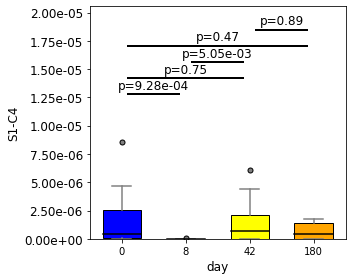

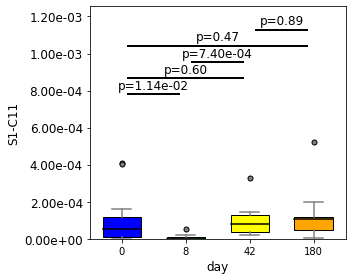

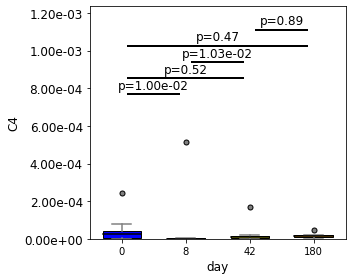

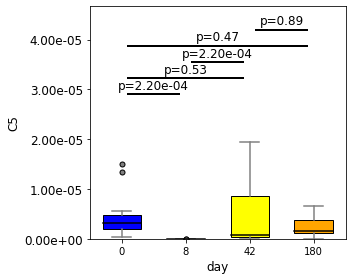

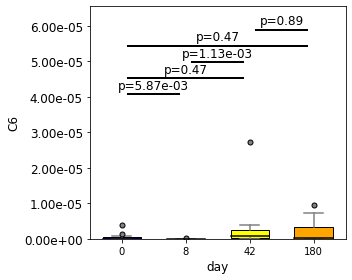

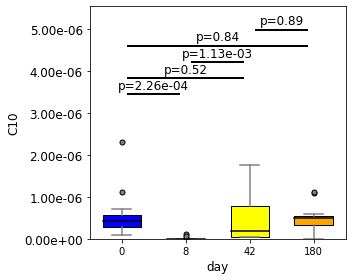

In [16]:
for cluster in e_day_df.index:
    fig, ax = plt.subplots(figsize=(5, 4))
    df = pd.DataFrame(columns=days, index=valid)
    for day in days:
        tmp = exposed_ev_dict[day] 
        df.loc[valid, day] = tmp.loc[valid, cluster]

    bp = ax.boxplot(df[days], labels=days, patch_artist=True, widths=0.6)
    colors = ['blue', 'green', 'yellow', 'orange']
    max_y = df.max().max()*1.5
    for box, color in zip(bp['boxes'], colors):
        box.set(facecolor=color, alpha=1)

    for whisker in bp['whiskers']:
        whisker.set(color='gray', linewidth=1.5)
    for cap in bp['caps']:
        cap.set(color='gray', linewidth=1.5)
    for median in bp['medians']:
        median.set(color='black', linewidth=1.5)
    for flier in bp['fliers']:
        flier.set(marker='o', markerfacecolor='gray', markersize=5)


    for i, pair in enumerate(e_day_df.columns):
        day0, day1 = pair.split('-')
        day0 = days.index(int(day0))
        day1 = days.index(int(day1))
        value = e_day_df.loc[cluster, pair]
        current_y = max_y*(1+i*0.11)
        ax.plot([1.1+day0, day1+0.9], [current_y]*2, '-', color='black', linewidth=2)
        if value < 0.05:
            ax.text((2+day0+day1)/2, current_y*1.01, "p={:.2e}".format(value), ha='center', va='bottom', fontsize=12)
        else:
            ax.text((2+day0+day1)/2, current_y*1.01, "p={:.2f}".format(value), ha='center', va='bottom', fontsize=12)

    #ax.set_title('SE comparison in different experiment')
    ax.set_xlabel('day', fontsize=12)
    ax.set_ylabel('{}'.format(cluster.split('_')[1]), fontsize=12)
    plt.yticks(fontsize=12)
    ax.set_ylim(0, max_y*1.6)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, '{}_boxplot.pdf'.format(cluster)), format='pdf')
    plt.show()


In [32]:
# check all abd diff
diff_abd_dict = {}
for d1 in days:
    if d1 not in diff_abd_dict.keys():
        diff_abd_dict[d1] = {}
    tmp1 = day_data_dict[d1]
    for d2 in days:
        if d1 >= d2:
            continue
        diff_abd_dict[d1][d2] = pd.DataFrame()
        tmp2 = day_data_dict[d2]
        for sp in tmp1.columns:
            #if list(tmp1[sp]).count(0) > len(tmp1)*0.8:
            #    continue
            if sp not in tmp2.columns:
                v2 = [0]*len(tmp1)
            v1 = tmp1[sp]
            v2 = tmp2[sp]
            t, p = mannwhitneyu(v1, v2)
            diff_abd_dict[d1][d2].loc[sp, 'p'] = p
        diff_abd_dict[d1][d2]['p_adj'] = fdr(list(diff_abd_dict[d1][d2]['p']), 0.05)[1]


In [33]:
for cluster in e_day_df.index:
    leaves = node_leaves[cluster]
    for d1 in days:
        for d2 in days:
            if d1 >= d2:
                continue
            total_tmp = 0
            sig_tmp = 0
            for sp in leaves:
                if sp not in diff_abd_dict[d1][d2].index:
                    continue
                p = diff_abd_dict[d1][d2].loc[sp, 'p_adj']
                total_tmp += 1
                if p < 0.05:
                    sig_tmp += 1
            if total_tmp is 0 :
                print(cluster)
                continue
            print(cluster, d1, d2, sig_tmp, total_tmp, sig_tmp/total_tmp)

cluster_S1-C4 0 8 16 34 0.47058823529411764
cluster_S1-C4 0 42 3 34 0.08823529411764706
cluster_S1-C4 0 180 0 34 0.0
cluster_S1-C4 8 42 14 34 0.4117647058823529
cluster_S1-C4 8 180 16 34 0.47058823529411764
cluster_S1-C4 42 180 0 34 0.0
cluster_S1-C11 0 8 2 8 0.25
cluster_S1-C11 0 42 0 8 0.0
cluster_S1-C11 0 180 0 8 0.0
cluster_S1-C11 8 42 4 8 0.5
cluster_S1-C11 8 180 3 8 0.375
cluster_S1-C11 42 180 0 8 0.0
cluster_C4 0 8 6 11 0.5454545454545454
cluster_C4 0 42 0 11 0.0
cluster_C4 0 180 0 11 0.0
cluster_C4 8 42 4 11 0.36363636363636365
cluster_C4 8 180 5 11 0.45454545454545453
cluster_C4 42 180 0 11 0.0
cluster_C5 0 8 4 7 0.5714285714285714
cluster_C5 0 42 2 7 0.2857142857142857
cluster_C5 0 180 0 7 0.0
cluster_C5 8 42 3 7 0.42857142857142855
cluster_C5 8 180 4 7 0.5714285714285714
cluster_C5 42 180 0 7 0.0
cluster_C6 0 8 3 7 0.42857142857142855
cluster_C6 0 42 0 7 0.0
cluster_C6 0 180 0 7 0.0
cluster_C6 8 42 2 7 0.2857142857142857
cluster_C6 8 180 2 7 0.2857142857142857
cluster_C6 42 

In [35]:
for cluster in ['root', 'supercluster_S1', 'cluster_S1-C2']:
    leaves = node_leaves[cluster]
    for d1 in days:
        for d2 in days:
            if d1 >= d2:
                continue
            total_tmp = 0
            sig_tmp = 0
            for sp in leaves:
                if sp not in diff_abd_dict[d1][d2].index:
                    continue
                p = diff_abd_dict[d1][d2].loc[sp, 'p_adj']
                total_tmp += 1
                if p < 0.05:
                    sig_tmp += 1
            print(cluster, d1, d2, sig_tmp, total_tmp, sig_tmp/total_tmp)

root 0 8 81 205 0.3951219512195122
root 0 42 14 205 0.06829268292682927
root 0 180 0 205 0.0
root 8 42 68 205 0.33170731707317075
root 8 180 77 205 0.375609756097561
root 42 180 0 205 0.0
supercluster_S1 0 8 63 168 0.375
supercluster_S1 0 42 12 168 0.07142857142857142
supercluster_S1 0 180 0 168 0.0
supercluster_S1 8 42 55 168 0.3273809523809524
supercluster_S1 8 180 61 168 0.3630952380952381
supercluster_S1 42 180 0 168 0.0
cluster_S1-C2 0 8 33 74 0.44594594594594594
cluster_S1-C2 0 42 8 74 0.10810810810810811
cluster_S1-C2 0 180 0 74 0.0
cluster_S1-C2 8 42 28 74 0.3783783783783784
cluster_S1-C2 8 180 29 74 0.3918918918918919
cluster_S1-C2 42 180 0 74 0.0


In [ ]:
# make heatmap for ev day
# exposed
mean_df = pd.DataFrame(index=node_leaves.keys(), columns=days)
median_df = pd.DataFrame(index=node_leaves.keys(), columns=days)
for day in days:
    tmp = exposed_ev_dict[day]
    mean_df.loc[tmp.columns, day] = tmp.mean()
    median_df.loc[tmp.columns, day] = tmp.median()

mean_df = mean_df.astype(float)
median_df = median_df.astype(float)
# delete all zero rows
mean_df = mean_df.loc[(mean_df!=0).any(axis=1), :]
median_df = median_df.loc[(median_df!=0).any(axis=1), :]

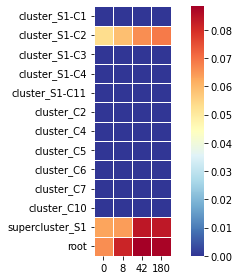

In [ ]:
sns.heatmap(mean_df, cmap='RdYlBu_r', square=True, linewidths=0.5, linecolor='white')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'exposed_TI_mean_heatmap.pdf'), format='pdf')
plt.show()

<AxesSubplot: >

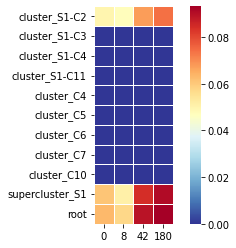

In [38]:
sns.heatmap(median_df, cmap='RdYlBu_r', square=True, linewidths=0.5, linecolor='white')


In [39]:
median_df

,0,8,42,180
cluster_S1-C2,4.986329e-02,4.712738e-02,6.770153e-02,7.418194e-02
cluster_S1-C3,0.000000e+00,2.536485e-07,0.000000e+00,0.000000e+00
cluster_S1-C4,4.217490e-07,0.000000e+00,7.019287e-07,4.497631e-07
cluster_S1-C11,5.453968e-05,1.596217e-06,7.870183e-05,1.092740e-04
cluster_C4,2.473359e-05,1.430414e-06,1.017506e-05,1.449075e-05
cluster_C5,3.200455e-06,0.000000e+00,8.410227e-07,1.646962e-06
cluster_C6,3.552986e-08,0.000000e+00,8.530441e-07,2.200964e-07
cluster_C7,2.848481e-06,1.608409e-06,5.209007e-06,2.631634e-06
cluster_C10,4.150885e-07,0.000000e+00,1.823731e-07,4.849056e-07
supercluster_S1,6.092469e-02,5.131366e-02,8.434324e-02,9.075479e-02
